In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [3]:
!pip install mlflow-skinny==2.7.1
!pip install -q python-dotenv

In [4]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [5]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


In [6]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [7]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2025.pkl'))

In [8]:
df.head()

,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,FG%,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,0.579,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,0.494,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,0.465,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,0.357,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,0.472,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [9]:
cols_tot_rank = [col for col in df.columns if '_tot' in col or '_rank' in col]
cols_to_drop = ['G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm', 'FG_tot', '3PA_tot', '2PA_tot', 'FGA_rank_tot', 'Tm', 'Pos', 'Age', 'G', 'GS', 'FGA_pg', 'FG%', '3P_pg', '3PA_pg', '3P%', '2PA_pg', '2P%', 'eFG%', 'FT%', 'ORB_pg', 'DRB_pg', 'PF_pg', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'OBPM', 'DBPM']
cols_to_drop += cols_tot_rank
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']

In [10]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('AdjustColumns', prep.AdjustCols(cols_to_adjust = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [11]:
df = pipe_clean.fit_transform(df)

In [12]:
df.head()

,,MP_pg,FG_pg,2P_pg,FT_pg,FTA_pg,TRB_pg,AST_pg,STL_pg,BLK_pg,TOV_pg,...,USG%,OWS,DWS,WS,WS/48,BPM,VORP,%W,%G,Share
Player,Season,,,,,,,,,,,,,,,,,,,,,
Kareem Abdul-Jabbar,1982,35.2,9.9,9.9,4.1,5.8,8.7,3.0,0.8,2.7,3.0,...,0.256,6.9,3.9,10.7,0.192,5.0,4.7,0.695,0.927,0.045
Alvan Adams,1982,30.3,6.4,6.4,2.3,2.9,7.4,4.5,1.4,1.0,2.5,...,0.228,2.5,4.7,7.2,0.144,3.6,3.4,0.561,0.963,0.000
Mark Aguirre,1982,28.8,7.5,7.0,3.3,4.8,4.9,3.2,0.7,0.4,2.6,...,0.298,1.0,0.8,1.9,0.061,0.7,1.0,0.341,0.622,0.000
Danny Ainge,1982,10.6,1.5,1.4,1.1,1.2,1.1,1.6,0.7,0.1,1.0,...,0.215,-0.3,0.8,0.5,0.042,-2.7,-0.1,0.768,0.646,0.000
Tiny Archibald,1982,31.9,4.5,4.4,3.5,4.6,1.7,8.0,0.8,0.0,2.6,...,0.179,3.4,1.8,5.2,0.115,0.1,1.1,0.768,0.829,0.000


In [13]:
len(df[df.index.get_level_values(1) > 2019]) / len(df)

0.17372466085521227

In [14]:
val_df = df[df.index.get_level_values(1) > 2019]
dev_df = df[df.index.get_level_values(1) <= 2019]

In [15]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [16]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [17]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [18]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [19]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [20]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [21]:
mlflow.set_experiment('XGBoost v2')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/6', creation_time=1730480765937, experiment_id='6', last_update_time=1730480765937, lifecycle_stage='active', name='XGBoost v2', tags={}>

In [22]:
param_grid = {
    'max_depth': [3],
    'colsample_bytree': [.7],
    'subsample': [.7],
    'n_estimators': [150],
    'learning_rate': [.2]
    }

In [23]:
with mlflow.start_run():
    estimator = xgb.XGBRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_xgb(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances_xgb(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val']))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   1.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.7; total time=   0.4s
[CV] END colsample_

In [24]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.019259,0.019678,0.023993
R2,0.985382,0.964825,0.807873


In [25]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

In [26]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Share,PredShare
Player,Season,,
Giannis Antetokounmpo,2020,0.952,0.658055
LeBron James,2020,0.746,0.322757
James Harden,2020,0.363,0.604983
Luka Dončić,2020,0.198,0.218712
Kawhi Leonard,2020,0.166,0.105582
Anthony Davis,2020,0.081,0.194176
Chris Paul,2020,0.026,-0.010877
Damian Lillard,2020,0.023,0.103641
Nikola Jokić,2020,0.018,0.051908


,,Share,PredShare
Player,Season,,
Nikola Jokić,2021,0.961,0.610279
Joel Embiid,2021,0.580,0.277259
Stephen Curry,2021,0.449,0.219249
Giannis Antetokounmpo,2021,0.345,0.227227
Chris Paul,2021,0.138,0.014992
Luka Dončić,2021,0.042,0.236895
Damian Lillard,2021,0.038,0.141790
Julius Randle,2021,0.020,-0.000309
Derrick Rose,2021,0.010,0.000278


,,Share,PredShare
Player,Season,,
Nikola Jokić,2022,0.875,0.599977
Joel Embiid,2022,0.706,0.536338
Giannis Antetokounmpo,2022,0.595,0.468404
Devin Booker,2022,0.216,0.139311
Luka Dončić,2022,0.146,0.281494
Jayson Tatum,2022,0.043,0.121849
Ja Morant,2022,0.010,0.166312
Stephen Curry,2022,0.004,0.018340
Chris Paul,2022,0.002,0.086229


,,Share,PredShare
Player,Season,,
Joel Embiid,2023,0.915,0.633073
Nikola Jokić,2023,0.674,0.544692
Giannis Antetokounmpo,2023,0.606,0.491243
Jayson Tatum,2023,0.280,0.274288
Shai Gilgeous-Alexander,2023,0.046,0.124787
Donovan Mitchell,2023,0.030,0.157560
Domantas Sabonis,2023,0.027,0.081762
Luka Dončić,2023,0.010,0.312222
Stephen Curry,2023,0.005,-0.002132


,,Share,PredShare
Player,Season,,
Nikola Jokić,2024,0.935,0.780974
Shai Gilgeous-Alexander,2024,0.646,0.522818
Luka Dončić,2024,0.572,0.516181
Giannis Antetokounmpo,2024,0.194,0.511615
Jalen Brunson,2024,0.143,0.136113
Jayson Tatum,2024,0.087,0.183651
Anthony Edwards,2024,0.018,0.079282
Domantas Sabonis,2024,0.003,0.141256
Kevin Durant,2024,0.001,0.067513


,,Share,PredShare
Player,Season,,
Shai Gilgeous-Alexander,2025,0.913,0.894680
Nikola Jokić,2025,0.787,0.589741
Giannis Antetokounmpo,2025,0.470,0.245168
Jayson Tatum,2025,0.311,0.203936
Donovan Mitchell,2025,0.074,0.021456
LeBron James,2025,0.016,0.079599
Anthony Edwards,2025,0.012,0.060275
Cade Cunningham,2025,0.012,-0.009225
Stephen Curry,2025,0.002,0.006407


No contenders results:


,,Share,PredShare
Player,Season,,
Steven Adams,2020,0.0,0.000626
Kyle Alexander,2020,0.0,0.000278
Nickeil Alexander-Walker,2020,0.0,0.000278
Grayson Allen,2020,0.0,0.000278
Jarrett Allen,2020,0.0,0.000617
...,...,...,...
Mac McClung,2025,0.0,0.000278
Riley Minix,2025,0.0,0.000278
Zyon Pullin,2025,0.0,0.000278


In [27]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Share,PredShare
Player,Season,,
Bradley Beal,2021,0.0,0.122298
Kevin Durant,2021,0.0,0.106491
Kyrie Irving,2021,0.0,0.123380
Trae Young,2022,0.0,0.117079
Jaylen Brown,2023,0.0,0.127821
Damian Lillard,2023,0.0,0.124702
Joel Embiid,2024,0.0,0.397077
Anthony Davis,2024,0.0,0.142184
Victor Wembanyama,2025,0.0,0.194740


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

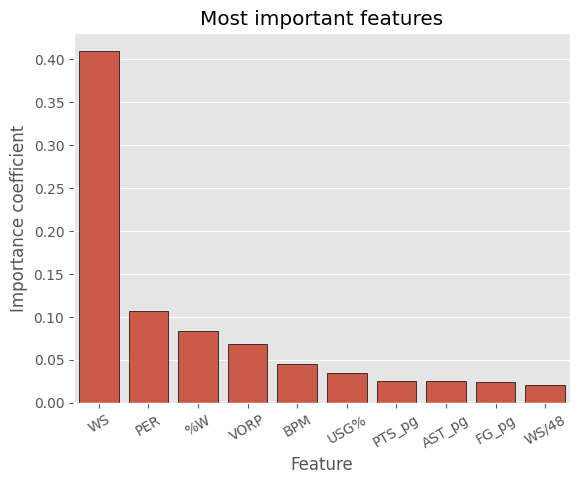

In [28]:
mod.display_feature_importances_xgb(best_model)

In [29]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'])

(<Figure size 4000x4000 with 6 Axes>, <Figure size 4000x4000 with 6 Axes>)

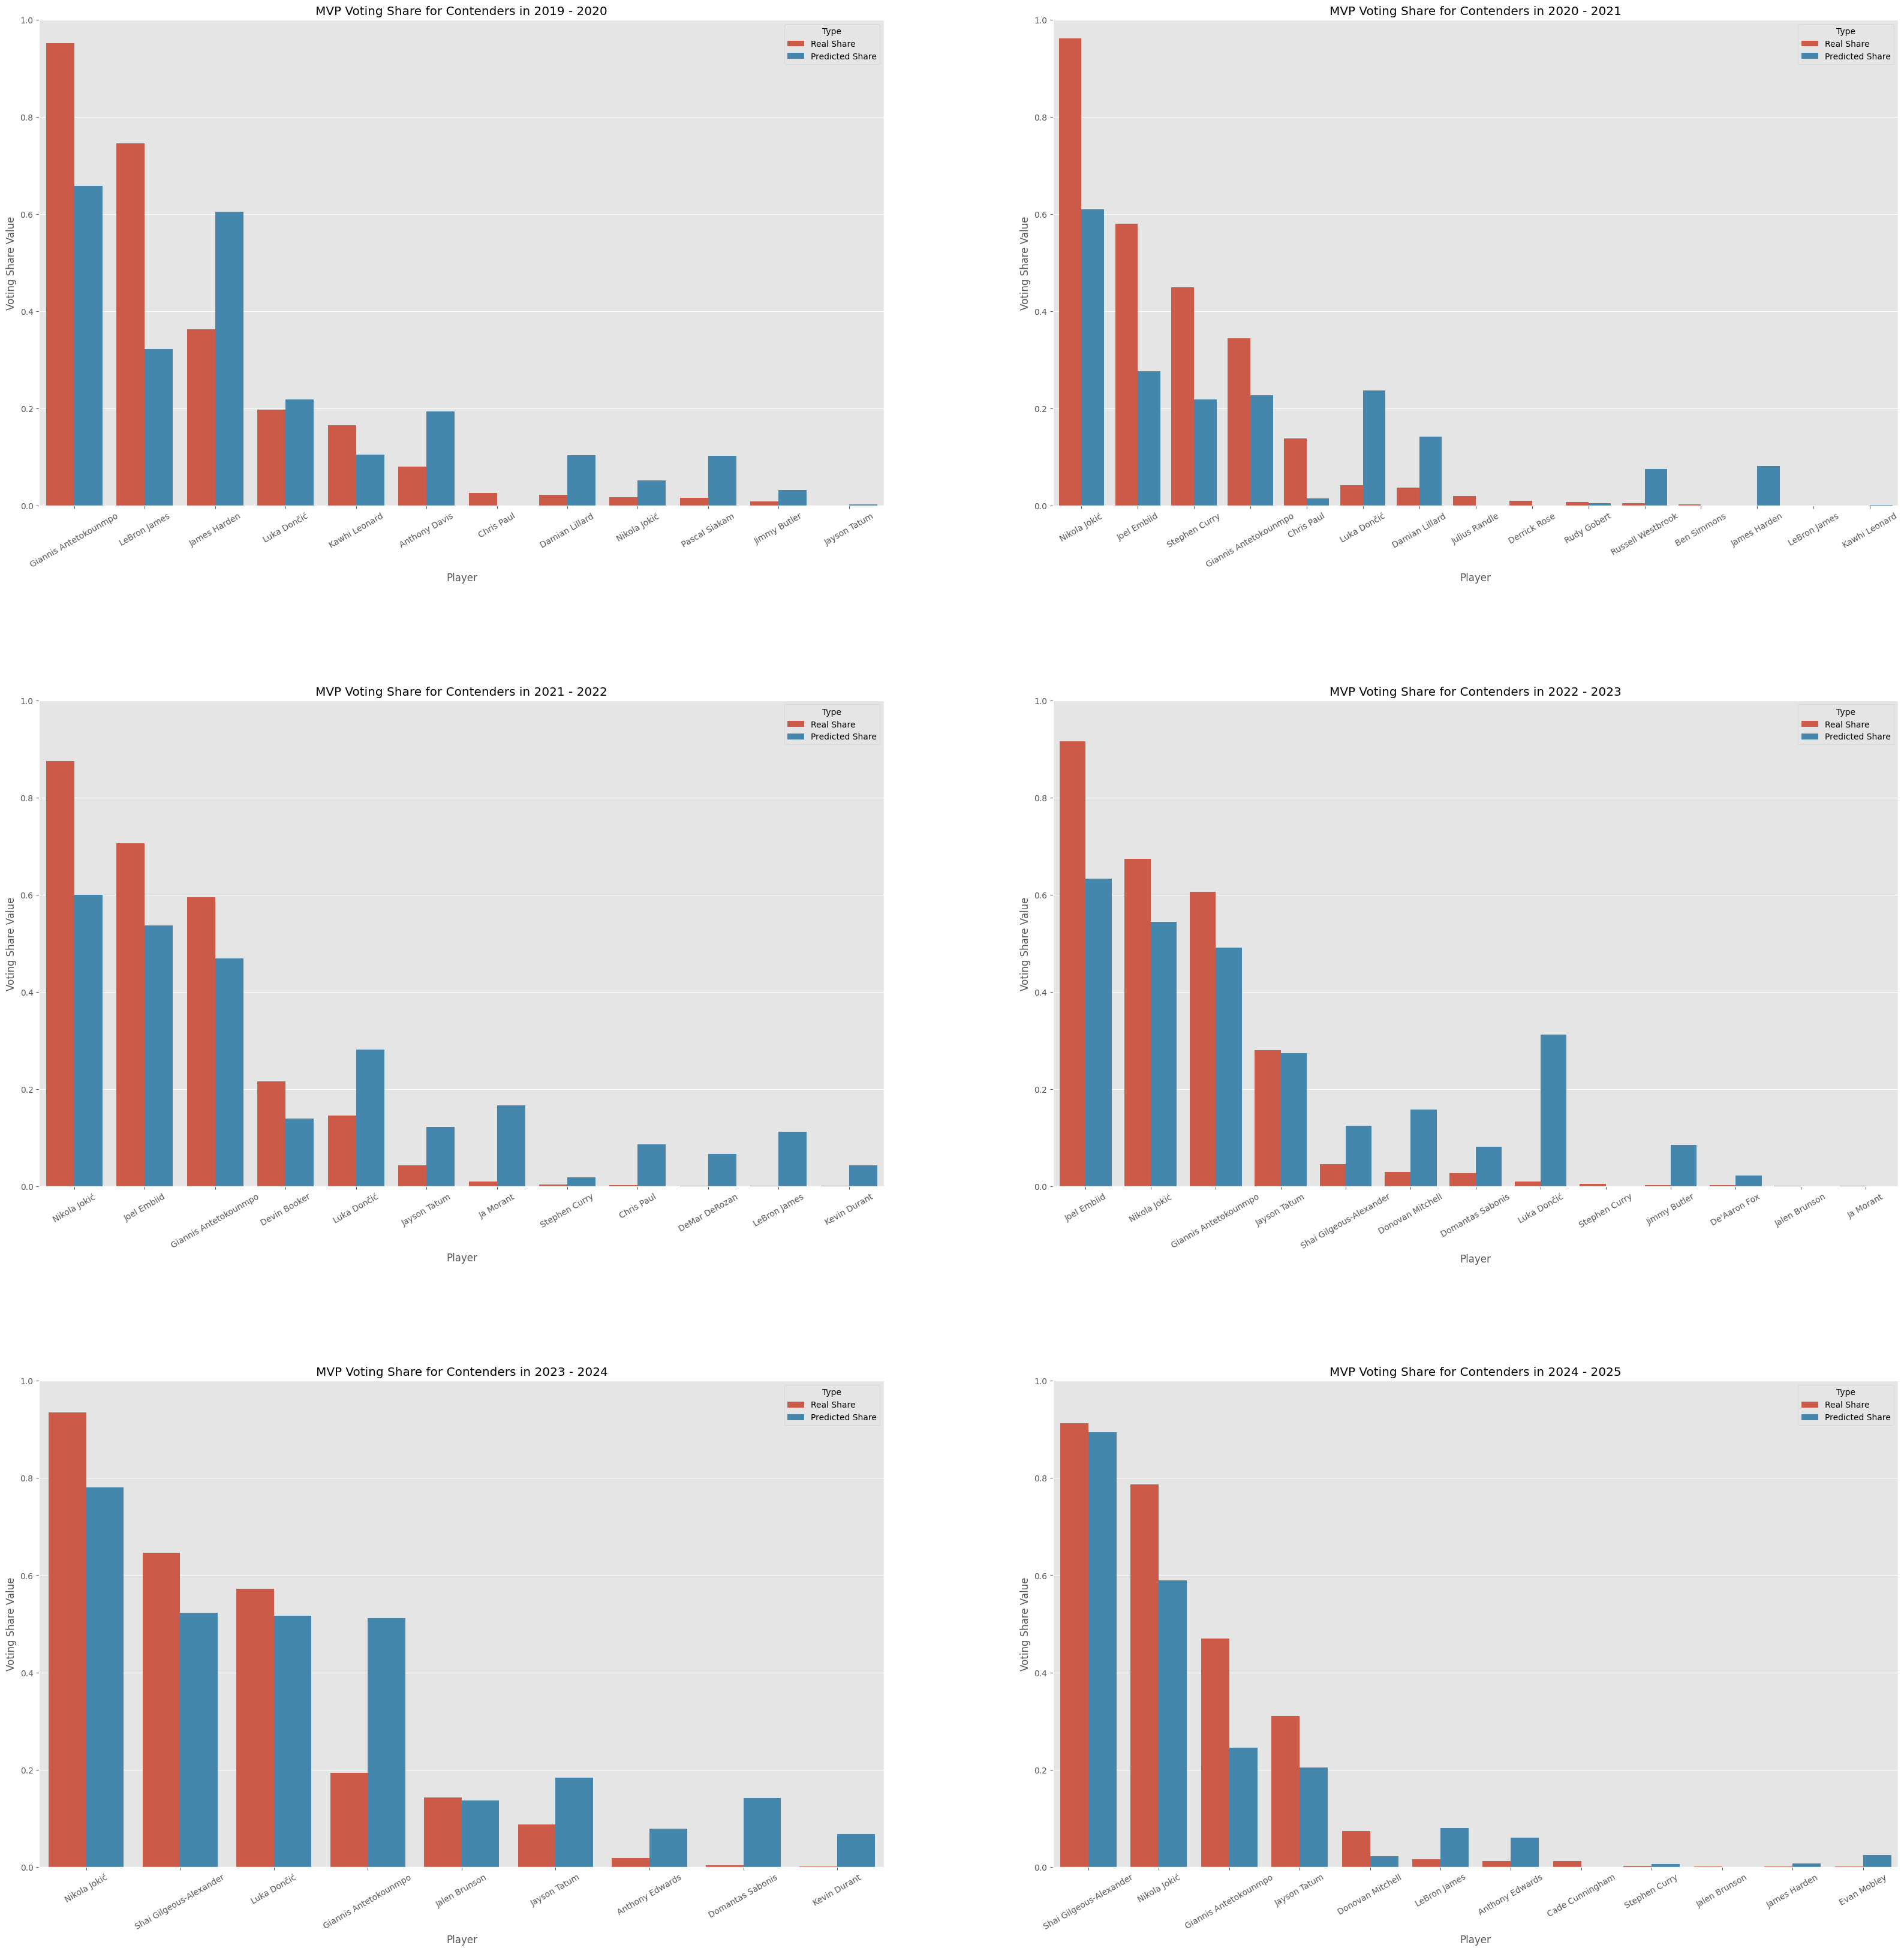

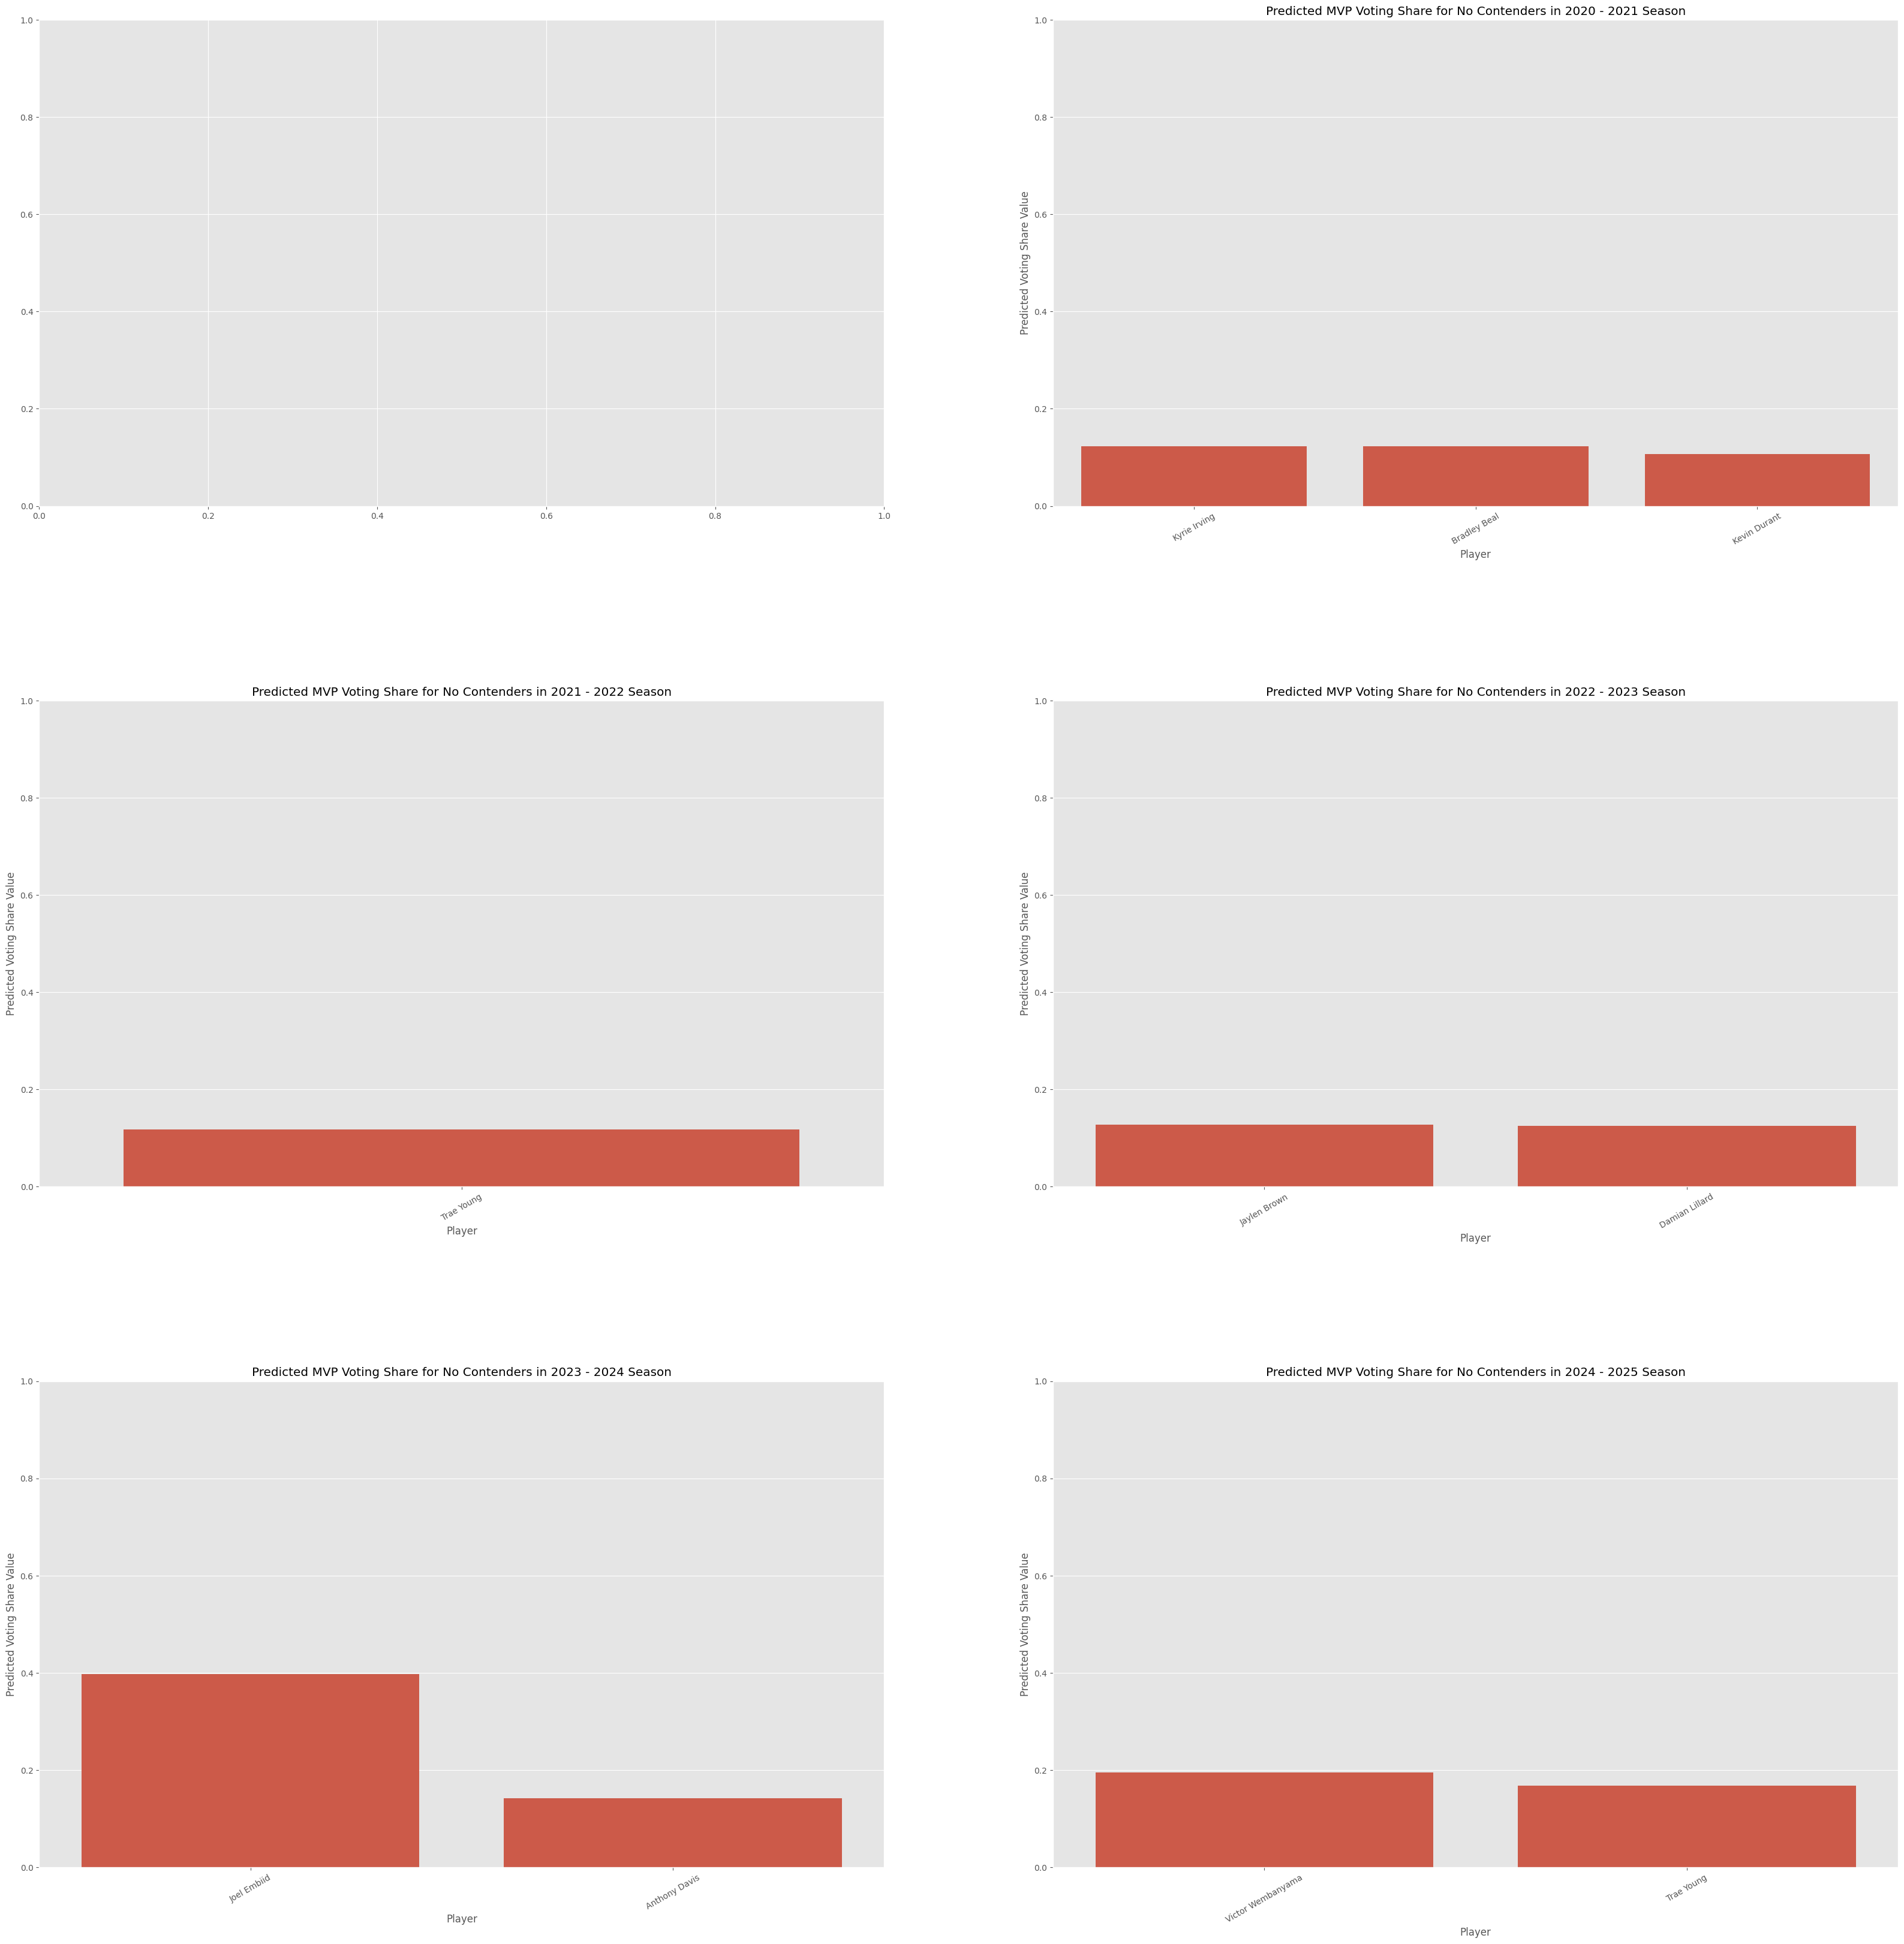

In [30]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'])